In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
import tqdm
import umap

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Load Data and Policy

In [3]:
# Read data files
adata, = celltrip.utility.processing.read_adatas('../data/VirtualCell/expression.h5ad', backed=True)  # 's3://nkalafut-celltrip/VirtualCell/expression.h5ad'
# Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251001', 800  # No mask
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251006', 800  # Normal
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007', 800  # 16 dim - Not much diff. betw. runs
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007-celllog', 800  # 16 dim - sample and log norm
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007-celllog-32', 800  # 32 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251008-celllog-64', 800  # 64 dim, 1024 PCA
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
# assert (adata.obs['training'] == mask).all()
# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=100, vision_size=1_000).eval().to('cuda')  # TODO Forward batch size reduced
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
preprocessing_nopca = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
preprocessing_nopca.pca_dim = None


# Generate Steady State

In [5]:
# # Get random sample
# np.random.seed(42)
# sample_idx = np.sort(np.random.choice(adata.obs.shape[0], 10_000, replace=False))
# m1_raw = celltrip.utility.processing.chunk(adata.X[sample_idx], chunk_size=2_000)
# m1, = preprocessing.transform([m1_raw])


In [6]:
# # Create environment
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), compute_rewards=False, dim=8).eval(time_scale=1).to('cuda')

# # Simulate
# ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
# steady_state = ret[-1][-1, :, :env.dim]
# # target_state = env.modalities[env.target_modalities[0]].cpu()

# # Impute
# with torch.no_grad():
#     imputed_steady_state = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()
# imputed_steady_state, = preprocessing.inverse_transform([imputed_steady_state])

# # Compute accuracy
# mse = np.square(m1_raw - imputed_steady_state).mean()
# print(f'MSE: {mse:.3f}')


In [7]:
# # Latent space plot
# red = umap.UMAP(random_state=42)
# df = pd.DataFrame(index=sample_idx)
# df[['X_lat', 'Y_lat']] = red.fit_transform(steady_state)
# df['Target'] = adata[sample_idx].obs['target_gene'].to_numpy()
# df['Select Targets'] = df['Target']
# df.loc[~df['Target'].isin(['TMSB4X', 'EWSR1', 'non-targeting']), 'Select Targets'] = 'Other'
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# sns.scatterplot(df, x='X_lat', y='Y_lat', hue='Select Targets', s=5, legend=True, ax=ax)


# Predict Perturbation Outcomes

In [8]:
# Get non-targeting
non_targeting_sample_idx = np.argwhere(adata.obs['target_gene']=='non-targeting').flatten()
np.random.seed(42)
non_targeting_sample_idx = np.sort(np.random.choice(non_targeting_sample_idx, 5_000, replace=False))  # Subsample for performance
non_targeting_raw = celltrip.utility.processing.chunk(adata.X[non_targeting_sample_idx], chunk_size=2_000)
non_targeting_trans, = preprocessing.transform([non_targeting_raw])

# Create environment
env = (
    celltrip.environment.EnvironmentBase(
        torch.tensor(non_targeting_trans), compute_rewards=False, dim=env.dim)
        .eval(time_scale=1)
        .set_incorporation_params(retention=1., binding=1.)  # Nothing at all
        .to('cuda'))

# Simulate (Runs at around .61x realtime on 38k cells!)
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
non_targeting_steady_state = ret[-1][-1]
print(f'Mean Velocity: {env.vel.abs().mean(dim=-1).mean():.3f}')

# Simulate with incorporation
# env.reset().set_state(non_targeting_steady_state.to('cuda'))
# ret = celltrip.train.simulate_until_completion(env, policy, incorporate_predictions=False, skip_states=100, store_states='cpu', progress_bar=True)
# env.solidify_offsets()
# non_targeting_steady_state = ret[-1][-1]
# print(env.vel.abs().mean(dim=-1).mean())

# Impute
with torch.no_grad():
    imputed_non_targeting_steady_state = policy.pinning[0](non_targeting_steady_state[..., :env.dim].to('cuda')).detach().cpu().numpy()
imputed_non_targeting_steady_state, = preprocessing.inverse_transform([imputed_non_targeting_steady_state])



0it [00:00, ?it/s]


1it [00:00,  3.59it/s]


2it [00:00,  5.34it/s]


3it [00:00,  6.34it/s]


4it [00:00,  6.97it/s]


5it [00:00,  7.37it/s]


6it [00:00,  7.64it/s]


7it [00:01,  7.82it/s]


8it [00:01,  7.95it/s]


9it [00:01,  8.03it/s]


10it [00:01,  8.11it/s]


11it [00:01,  8.16it/s]


12it [00:01,  8.20it/s]


13it [00:01,  8.23it/s]


14it [00:01,  8.25it/s]


15it [00:01,  8.17it/s]


16it [00:02,  8.20it/s]


17it [00:02,  8.23it/s]


18it [00:02,  8.25it/s]


19it [00:02,  8.26it/s]


20it [00:02,  8.27it/s]


21it [00:02,  8.28it/s]


22it [00:02,  8.29it/s]


23it [00:02,  8.28it/s]


24it [00:03,  8.29it/s]


25it [00:03,  8.29it/s]


26it [00:03,  8.30it/s]


27it [00:03,  8.30it/s]


28it [00:03,  8.30it/s]


29it [00:03,  8.31it/s]


30it [00:03,  8.31it/s]


31it [00:03,  8.31it/s]


32it [00:04,  8.31it/s]


33it [00:04,  8.31it/s]


34it [00:04,  8.31it/s]


35it [00:04,  8.31it/s]


36it [00:04,  8.31it/s]


37it [00:04,  8.32it/s]


38it [00:04,  8.31it/s]


39it [00:04,  8.31it/s]


40it [00:04,  8.31it/s]


41it [00:05,  8.31it/s]


42it [00:05,  8.31it/s]


43it [00:05,  8.31it/s]


44it [00:05,  8.26it/s]


45it [00:05,  8.27it/s]


46it [00:05,  8.28it/s]


47it [00:05,  8.29it/s]


48it [00:05,  8.29it/s]


49it [00:06,  8.30it/s]


50it [00:06,  8.30it/s]


51it [00:06,  8.29it/s]


52it [00:06,  8.30it/s]


53it [00:06,  8.30it/s]


54it [00:06,  8.30it/s]


55it [00:06,  8.30it/s]


56it [00:06,  8.30it/s]


57it [00:07,  8.31it/s]


58it [00:07,  8.31it/s]


59it [00:07,  8.31it/s]


60it [00:07,  8.30it/s]


61it [00:07,  8.31it/s]


62it [00:07,  8.31it/s]


63it [00:07,  8.31it/s]


64it [00:07,  8.31it/s]


65it [00:08,  8.31it/s]


66it [00:08,  8.31it/s]


67it [00:08,  8.31it/s]


68it [00:08,  8.31it/s]


69it [00:08,  8.31it/s]


70it [00:08,  8.18it/s]


71it [00:08,  8.22it/s]


72it [00:08,  8.25it/s]


73it [00:08,  8.26it/s]


74it [00:09,  8.28it/s]


75it [00:09,  8.29it/s]


76it [00:09,  8.29it/s]


77it [00:09,  8.29it/s]


78it [00:09,  8.30it/s]


79it [00:09,  8.30it/s]


80it [00:09,  8.31it/s]


81it [00:09,  8.30it/s]


82it [00:10,  8.30it/s]


83it [00:10,  8.30it/s]


84it [00:10,  8.31it/s]


85it [00:10,  8.30it/s]


86it [00:10,  8.30it/s]


87it [00:10,  8.31it/s]


88it [00:10,  8.31it/s]


89it [00:10,  8.31it/s]


90it [00:11,  8.31it/s]


91it [00:11,  8.31it/s]


92it [00:11,  8.31it/s]


93it [00:11,  8.31it/s]


94it [00:11,  8.30it/s]


95it [00:11,  8.30it/s]


96it [00:11,  8.30it/s]


97it [00:11,  8.31it/s]


98it [00:11,  8.30it/s]


99it [00:12,  8.30it/s]


100it [00:12,  8.29it/s]


101it [00:12,  8.29it/s]


102it [00:12,  8.30it/s]


103it [00:12,  8.30it/s]


104it [00:12,  8.30it/s]


105it [00:12,  8.30it/s]


106it [00:12,  8.29it/s]


107it [00:13,  8.29it/s]


108it [00:13,  8.30it/s]


109it [00:13,  8.30it/s]


110it [00:13,  8.30it/s]


111it [00:13,  8.30it/s]


112it [00:13,  8.31it/s]


113it [00:13,  8.30it/s]


114it [00:13,  8.30it/s]


115it [00:14,  8.30it/s]


116it [00:14,  8.31it/s]


117it [00:14,  8.30it/s]


118it [00:14,  8.30it/s]


119it [00:14,  8.30it/s]


120it [00:14,  8.30it/s]


121it [00:14,  8.30it/s]


122it [00:14,  8.30it/s]


123it [00:14,  8.30it/s]


124it [00:15,  8.30it/s]


125it [00:15,  8.29it/s]


126it [00:15,  8.29it/s]


127it [00:15,  8.30it/s]


128it [00:15,  8.30it/s]


129it [00:15,  8.30it/s]


130it [00:15,  8.31it/s]


131it [00:15,  8.30it/s]


132it [00:16,  8.30it/s]


133it [00:16,  8.30it/s]


134it [00:16,  8.31it/s]


135it [00:16,  8.31it/s]


136it [00:16,  8.31it/s]


137it [00:16,  8.31it/s]


138it [00:16,  8.31it/s]


139it [00:16,  8.30it/s]


140it [00:17,  8.30it/s]


141it [00:17,  8.30it/s]


142it [00:17,  8.30it/s]


143it [00:17,  8.30it/s]


144it [00:17,  8.29it/s]


145it [00:17,  8.29it/s]


146it [00:17,  8.29it/s]


147it [00:17,  8.28it/s]


148it [00:18,  8.30it/s]


149it [00:18,  8.30it/s]


150it [00:18,  8.30it/s]


151it [00:18,  8.30it/s]


152it [00:18,  8.30it/s]


153it [00:18,  8.30it/s]


154it [00:18,  8.30it/s]


155it [00:18,  8.30it/s]


156it [00:18,  8.30it/s]


157it [00:19,  8.30it/s]


158it [00:19,  8.29it/s]


159it [00:19,  8.30it/s]


160it [00:19,  8.30it/s]


161it [00:19,  8.30it/s]


162it [00:19,  8.30it/s]


163it [00:19,  8.30it/s]


164it [00:19,  8.30it/s]


165it [00:20,  8.29it/s]


166it [00:20,  8.29it/s]


167it [00:20,  8.29it/s]


168it [00:20,  8.29it/s]


169it [00:20,  8.30it/s]


170it [00:20,  8.30it/s]


171it [00:20,  8.30it/s]


172it [00:20,  8.29it/s]


173it [00:21,  8.29it/s]


174it [00:21,  8.29it/s]


175it [00:21,  8.29it/s]


176it [00:21,  8.29it/s]


177it [00:21,  8.29it/s]


178it [00:21,  8.29it/s]


179it [00:21,  8.29it/s]


180it [00:21,  8.29it/s]


181it [00:21,  8.29it/s]


182it [00:22,  8.30it/s]


183it [00:22,  8.29it/s]


184it [00:22,  8.29it/s]


185it [00:22,  8.29it/s]


186it [00:22,  8.29it/s]


187it [00:22,  8.30it/s]


188it [00:22,  8.29it/s]


189it [00:22,  8.28it/s]


190it [00:23,  8.27it/s]


191it [00:23,  8.28it/s]


192it [00:23,  8.28it/s]


193it [00:23,  8.28it/s]


194it [00:23,  8.29it/s]


195it [00:23,  8.29it/s]


196it [00:23,  8.29it/s]


197it [00:23,  8.29it/s]


198it [00:24,  8.30it/s]


199it [00:24,  8.30it/s]


200it [00:24,  8.29it/s]


201it [00:24,  8.29it/s]


202it [00:24,  8.30it/s]


203it [00:24,  8.29it/s]


204it [00:24,  8.29it/s]


205it [00:24,  8.29it/s]


206it [00:25,  8.30it/s]


207it [00:25,  8.30it/s]


208it [00:25,  8.30it/s]


209it [00:25,  8.30it/s]


210it [00:25,  8.30it/s]


211it [00:25,  8.30it/s]


212it [00:25,  8.30it/s]


213it [00:25,  8.29it/s]


214it [00:25,  8.29it/s]


215it [00:26,  8.30it/s]


216it [00:26,  8.29it/s]


217it [00:26,  8.29it/s]


218it [00:26,  8.29it/s]


219it [00:26,  8.29it/s]


220it [00:26,  8.30it/s]


221it [00:26,  8.30it/s]


222it [00:26,  8.30it/s]


223it [00:27,  8.30it/s]


224it [00:27,  8.30it/s]


225it [00:27,  8.30it/s]


226it [00:27,  8.30it/s]


227it [00:27,  8.30it/s]


228it [00:27,  8.30it/s]


229it [00:27,  8.25it/s]


230it [00:27,  8.26it/s]


231it [00:28,  8.28it/s]


232it [00:28,  8.29it/s]


233it [00:28,  8.28it/s]


234it [00:28,  8.29it/s]


235it [00:28,  8.29it/s]


236it [00:28,  8.29it/s]


237it [00:28,  8.30it/s]


238it [00:28,  8.29it/s]


239it [00:28,  8.30it/s]


240it [00:29,  8.30it/s]


241it [00:29,  8.30it/s]


242it [00:29,  8.30it/s]


243it [00:29,  8.29it/s]


244it [00:29,  8.29it/s]


245it [00:29,  8.29it/s]


246it [00:29,  8.30it/s]


247it [00:29,  8.29it/s]


248it [00:30,  8.28it/s]


249it [00:30,  8.29it/s]


250it [00:30,  8.29it/s]


251it [00:30,  8.29it/s]


252it [00:30,  8.30it/s]


253it [00:30,  8.29it/s]


254it [00:30,  8.29it/s]


255it [00:30,  8.29it/s]


256it [00:31,  8.29it/s]


257it [00:31,  8.29it/s]


258it [00:31,  8.27it/s]


259it [00:31,  8.25it/s]


260it [00:31,  8.24it/s]


261it [00:31,  8.23it/s]


262it [00:31,  8.23it/s]


263it [00:31,  8.23it/s]


264it [00:32,  8.22it/s]


265it [00:32,  8.22it/s]


266it [00:32,  8.22it/s]


267it [00:32,  8.22it/s]


268it [00:32,  8.22it/s]


269it [00:32,  8.22it/s]


270it [00:32,  8.22it/s]


271it [00:32,  8.22it/s]


272it [00:32,  8.22it/s]


273it [00:33,  8.22it/s]


274it [00:33,  8.21it/s]


275it [00:33,  8.22it/s]


276it [00:33,  8.22it/s]


277it [00:33,  8.22it/s]


278it [00:33,  8.22it/s]


279it [00:33,  8.22it/s]


280it [00:33,  8.22it/s]


281it [00:34,  8.22it/s]


282it [00:34,  8.22it/s]


283it [00:34,  8.22it/s]


284it [00:34,  8.16it/s]


285it [00:34,  8.17it/s]


286it [00:34,  8.19it/s]


287it [00:34,  8.20it/s]


288it [00:34,  8.20it/s]


289it [00:35,  8.21it/s]


290it [00:35,  8.22it/s]


291it [00:35,  8.22it/s]


292it [00:35,  8.22it/s]


293it [00:35,  8.22it/s]


294it [00:35,  8.22it/s]


295it [00:35,  8.22it/s]


296it [00:35,  8.22it/s]


297it [00:36,  8.22it/s]


298it [00:36,  8.22it/s]


299it [00:36,  8.22it/s]


300it [00:36,  8.21it/s]


301it [00:36,  8.21it/s]


302it [00:36,  8.21it/s]


303it [00:36,  8.21it/s]


304it [00:36,  8.21it/s]


305it [00:36,  8.22it/s]


306it [00:37,  8.23it/s]


307it [00:37,  8.22it/s]


308it [00:37,  8.22it/s]


309it [00:37,  8.22it/s]


310it [00:37,  8.22it/s]


311it [00:37,  8.23it/s]


312it [00:37,  8.23it/s]


313it [00:37,  8.22it/s]


314it [00:38,  8.22it/s]


315it [00:38,  8.21it/s]


316it [00:38,  8.22it/s]


317it [00:38,  8.22it/s]


318it [00:38,  8.22it/s]


319it [00:38,  8.22it/s]


320it [00:38,  8.22it/s]


321it [00:38,  8.22it/s]


322it [00:39,  8.22it/s]


323it [00:39,  8.21it/s]


324it [00:39,  8.22it/s]


325it [00:39,  8.22it/s]


326it [00:39,  8.22it/s]


327it [00:39,  8.22it/s]


328it [00:39,  8.22it/s]


329it [00:39,  8.22it/s]


330it [00:40,  8.22it/s]


331it [00:40,  8.22it/s]


332it [00:40,  8.22it/s]


333it [00:40,  8.22it/s]


334it [00:40,  8.22it/s]


335it [00:40,  8.22it/s]


336it [00:40,  8.22it/s]


337it [00:40,  8.22it/s]


338it [00:41,  8.21it/s]


339it [00:41,  8.21it/s]


340it [00:41,  8.22it/s]


341it [00:41,  8.21it/s]


342it [00:41,  8.22it/s]


343it [00:41,  8.21it/s]


344it [00:41,  8.21it/s]


345it [00:41,  8.21it/s]


346it [00:41,  8.20it/s]


347it [00:42,  8.20it/s]


348it [00:42,  8.20it/s]


349it [00:42,  8.20it/s]


350it [00:42,  8.20it/s]


351it [00:42,  8.20it/s]


352it [00:42,  8.21it/s]


353it [00:42,  8.21it/s]


354it [00:42,  8.21it/s]


355it [00:43,  8.20it/s]


356it [00:43,  8.21it/s]


357it [00:43,  8.21it/s]


358it [00:43,  8.21it/s]


359it [00:43,  8.21it/s]


360it [00:43,  8.21it/s]


361it [00:43,  8.21it/s]


362it [00:43,  8.21it/s]


363it [00:44,  8.21it/s]


364it [00:44,  8.21it/s]


365it [00:44,  8.21it/s]


366it [00:44,  8.21it/s]


367it [00:44,  8.22it/s]


368it [00:44,  8.22it/s]


369it [00:44,  8.22it/s]


370it [00:44,  8.22it/s]


371it [00:45,  8.23it/s]


372it [00:45,  8.23it/s]


373it [00:45,  8.22it/s]


374it [00:45,  8.23it/s]


375it [00:45,  8.23it/s]


376it [00:45,  8.22it/s]


377it [00:45,  8.22it/s]


378it [00:45,  8.22it/s]


379it [00:46,  8.22it/s]


380it [00:46,  8.22it/s]


381it [00:46,  8.22it/s]


382it [00:46,  8.22it/s]


383it [00:46,  8.22it/s]


384it [00:46,  8.22it/s]


385it [00:46,  8.21it/s]


386it [00:46,  8.21it/s]


387it [00:46,  8.21it/s]


388it [00:47,  8.22it/s]


389it [00:47,  8.20it/s]


390it [00:47,  8.21it/s]


391it [00:47,  8.21it/s]


392it [00:47,  8.22it/s]


393it [00:47,  8.22it/s]


394it [00:47,  8.22it/s]


395it [00:47,  8.21it/s]


396it [00:48,  8.22it/s]


397it [00:48,  8.22it/s]


398it [00:48,  8.22it/s]


399it [00:48,  8.22it/s]


400it [00:48,  8.21it/s]


401it [00:48,  8.21it/s]


402it [00:48,  8.20it/s]


403it [00:48,  8.20it/s]


404it [00:49,  8.20it/s]


405it [00:49,  8.21it/s]


406it [00:49,  8.22it/s]


407it [00:49,  8.22it/s]


408it [00:49,  8.22it/s]


409it [00:49,  8.22it/s]


410it [00:49,  8.22it/s]


411it [00:49,  8.16it/s]


412it [00:50,  8.18it/s]


413it [00:50,  8.19it/s]


414it [00:50,  8.20it/s]


415it [00:50,  8.21it/s]


416it [00:50,  8.21it/s]


417it [00:50,  8.20it/s]


418it [00:50,  8.21it/s]


419it [00:50,  8.21it/s]


420it [00:50,  8.21it/s]


421it [00:51,  8.21it/s]


422it [00:51,  8.21it/s]


423it [00:51,  8.21it/s]


424it [00:51,  8.21it/s]


425it [00:51,  8.21it/s]


426it [00:51,  8.21it/s]


427it [00:51,  8.22it/s]


428it [00:51,  8.21it/s]


429it [00:52,  8.22it/s]


430it [00:52,  8.22it/s]


431it [00:52,  8.22it/s]


432it [00:52,  8.22it/s]


433it [00:52,  8.22it/s]


434it [00:52,  8.22it/s]


435it [00:52,  8.23it/s]


436it [00:52,  8.22it/s]


437it [00:53,  8.22it/s]


438it [00:53,  8.23it/s]


439it [00:53,  8.22it/s]


440it [00:53,  8.23it/s]


441it [00:53,  8.23it/s]


442it [00:53,  8.23it/s]


443it [00:53,  8.23it/s]


444it [00:53,  8.23it/s]


445it [00:54,  8.23it/s]


446it [00:54,  8.22it/s]


447it [00:54,  8.22it/s]


448it [00:54,  8.23it/s]


449it [00:54,  8.21it/s]


450it [00:54,  8.22it/s]


451it [00:54,  8.22it/s]


452it [00:54,  8.22it/s]


453it [00:55,  8.22it/s]


454it [00:55,  8.22it/s]


455it [00:55,  8.22it/s]


456it [00:55,  8.22it/s]


457it [00:55,  8.22it/s]


458it [00:55,  8.23it/s]


459it [00:55,  8.23it/s]


460it [00:55,  8.23it/s]


461it [00:55,  8.22it/s]


462it [00:56,  8.22it/s]


463it [00:56,  8.22it/s]


464it [00:56,  8.21it/s]


465it [00:56,  8.21it/s]


466it [00:56,  8.21it/s]


467it [00:56,  8.21it/s]


468it [00:56,  8.21it/s]


469it [00:56,  8.21it/s]


470it [00:57,  8.22it/s]


471it [00:57,  8.22it/s]


472it [00:57,  8.22it/s]


473it [00:57,  8.22it/s]


474it [00:57,  8.22it/s]


475it [00:57,  8.22it/s]


476it [00:57,  8.22it/s]


477it [00:57,  8.22it/s]


478it [00:58,  8.22it/s]


479it [00:58,  8.22it/s]


480it [00:58,  8.21it/s]


481it [00:58,  8.22it/s]


482it [00:58,  8.22it/s]


483it [00:58,  8.21it/s]


484it [00:58,  8.21it/s]


485it [00:58,  8.22it/s]


486it [00:59,  8.17it/s]


487it [00:59,  8.19it/s]


488it [00:59,  8.20it/s]


489it [00:59,  8.21it/s]


490it [00:59,  8.21it/s]


491it [00:59,  8.21it/s]


492it [00:59,  8.22it/s]


493it [00:59,  8.22it/s]


494it [01:00,  8.22it/s]


495it [01:00,  8.22it/s]


496it [01:00,  8.23it/s]


497it [01:00,  8.23it/s]


498it [01:00,  8.22it/s]


499it [01:00,  8.23it/s]


500it [01:00,  8.22it/s]


501it [01:00,  8.22it/s]


502it [01:00,  8.22it/s]


503it [01:01,  8.21it/s]


504it [01:01,  8.22it/s]


505it [01:01,  8.22it/s]


506it [01:01,  8.22it/s]


507it [01:01,  8.23it/s]


508it [01:01,  8.23it/s]


509it [01:01,  8.23it/s]


510it [01:01,  8.22it/s]


511it [01:02,  8.23it/s]


512it [01:02,  8.23it/s]


513it [01:02,  8.23it/s]


514it [01:02,  8.23it/s]


515it [01:02,  8.23it/s]


516it [01:02,  8.23it/s]


517it [01:02,  8.23it/s]


518it [01:02,  8.23it/s]


519it [01:03,  8.23it/s]


520it [01:03,  8.23it/s]


521it [01:03,  8.23it/s]


522it [01:03,  8.24it/s]


523it [01:03,  8.24it/s]


524it [01:03,  8.23it/s]


525it [01:03,  8.23it/s]


526it [01:03,  8.23it/s]


527it [01:04,  8.23it/s]


528it [01:04,  8.23it/s]


529it [01:04,  8.24it/s]


530it [01:04,  8.24it/s]


531it [01:04,  8.24it/s]


532it [01:04,  8.24it/s]


533it [01:04,  8.24it/s]


534it [01:04,  8.24it/s]


535it [01:04,  8.23it/s]


536it [01:05,  8.23it/s]


537it [01:05,  8.23it/s]


538it [01:05,  8.24it/s]


539it [01:05,  8.24it/s]


540it [01:05,  8.24it/s]


541it [01:05,  8.24it/s]


542it [01:05,  8.24it/s]


543it [01:05,  8.24it/s]


544it [01:06,  8.24it/s]


545it [01:06,  8.23it/s]


546it [01:06,  8.23it/s]


547it [01:06,  8.23it/s]


548it [01:06,  8.23it/s]


549it [01:06,  8.24it/s]


550it [01:06,  8.17it/s]


551it [01:06,  8.19it/s]


552it [01:07,  8.20it/s]


553it [01:07,  8.21it/s]


554it [01:07,  8.21it/s]


555it [01:07,  8.22it/s]


556it [01:07,  8.22it/s]


557it [01:07,  8.23it/s]


558it [01:07,  8.23it/s]


559it [01:07,  8.23it/s]


560it [01:08,  8.23it/s]


561it [01:08,  8.22it/s]


562it [01:08,  8.22it/s]


563it [01:08,  8.22it/s]


564it [01:08,  8.22it/s]


565it [01:08,  8.22it/s]


566it [01:08,  8.23it/s]


567it [01:08,  8.23it/s]


568it [01:08,  8.22it/s]


569it [01:09,  8.23it/s]


570it [01:09,  8.23it/s]


571it [01:09,  8.23it/s]


572it [01:09,  8.23it/s]


573it [01:09,  8.23it/s]


574it [01:09,  8.22it/s]


575it [01:09,  8.23it/s]


576it [01:09,  8.22it/s]


577it [01:10,  8.22it/s]


578it [01:10,  8.23it/s]


579it [01:10,  8.23it/s]


580it [01:10,  8.22it/s]


581it [01:10,  8.22it/s]


582it [01:10,  8.23it/s]


583it [01:10,  8.22it/s]


584it [01:10,  8.22it/s]


585it [01:11,  8.22it/s]


586it [01:11,  8.22it/s]


587it [01:11,  8.22it/s]


588it [01:11,  8.22it/s]


589it [01:11,  8.22it/s]


590it [01:11,  8.22it/s]


591it [01:11,  8.22it/s]


592it [01:11,  8.23it/s]


593it [01:12,  8.22it/s]


594it [01:12,  8.22it/s]


595it [01:12,  8.22it/s]


596it [01:12,  8.22it/s]


597it [01:12,  8.22it/s]


598it [01:12,  8.22it/s]


599it [01:12,  8.22it/s]


600it [01:12,  8.21it/s]


601it [01:13,  8.21it/s]


602it [01:13,  8.22it/s]


603it [01:13,  8.22it/s]


604it [01:13,  8.22it/s]


605it [01:13,  8.22it/s]


606it [01:13,  8.23it/s]


607it [01:13,  8.23it/s]


608it [01:13,  8.23it/s]


609it [01:13,  8.22it/s]


610it [01:14,  8.23it/s]


611it [01:14,  8.23it/s]


612it [01:14,  8.23it/s]


613it [01:14,  8.23it/s]


614it [01:14,  8.23it/s]


615it [01:14,  8.23it/s]


616it [01:14,  8.23it/s]


617it [01:14,  8.22it/s]


618it [01:15,  8.22it/s]


619it [01:15,  8.22it/s]


620it [01:15,  8.22it/s]


621it [01:15,  8.22it/s]


622it [01:15,  8.21it/s]


623it [01:15,  8.22it/s]


624it [01:15,  8.22it/s]


625it [01:15,  8.22it/s]


626it [01:16,  8.22it/s]


627it [01:16,  8.22it/s]


628it [01:16,  8.22it/s]


629it [01:16,  8.22it/s]


630it [01:16,  8.22it/s]


631it [01:16,  8.22it/s]


632it [01:16,  8.22it/s]


633it [01:16,  8.21it/s]


634it [01:17,  8.21it/s]


635it [01:17,  8.22it/s]


636it [01:17,  8.22it/s]


637it [01:17,  8.22it/s]


638it [01:17,  8.22it/s]


639it [01:17,  8.22it/s]


640it [01:17,  8.23it/s]


641it [01:17,  8.23it/s]


642it [01:17,  8.23it/s]


643it [01:18,  8.23it/s]


644it [01:18,  8.22it/s]


645it [01:18,  8.20it/s]


646it [01:18,  8.21it/s]


647it [01:18,  8.21it/s]


648it [01:18,  8.22it/s]


649it [01:18,  8.23it/s]


650it [01:18,  8.23it/s]


651it [01:19,  8.23it/s]


652it [01:19,  8.23it/s]


653it [01:19,  8.23it/s]


654it [01:19,  8.23it/s]


655it [01:19,  8.23it/s]


656it [01:19,  8.23it/s]


657it [01:19,  8.23it/s]


658it [01:19,  8.23it/s]


659it [01:20,  8.23it/s]


660it [01:20,  8.23it/s]


661it [01:20,  8.23it/s]


662it [01:20,  8.22it/s]


663it [01:20,  8.23it/s]


664it [01:20,  8.22it/s]


665it [01:20,  8.22it/s]


666it [01:20,  8.23it/s]


667it [01:21,  8.23it/s]


668it [01:21,  8.23it/s]


669it [01:21,  8.23it/s]


670it [01:21,  8.23it/s]


671it [01:21,  8.23it/s]


672it [01:21,  8.23it/s]


673it [01:21,  8.23it/s]


674it [01:21,  8.23it/s]


675it [01:22,  8.23it/s]


676it [01:22,  8.23it/s]


677it [01:22,  8.23it/s]


678it [01:22,  8.23it/s]


679it [01:22,  8.23it/s]


680it [01:22,  8.23it/s]


681it [01:22,  8.23it/s]


682it [01:22,  8.23it/s]


683it [01:22,  8.22it/s]


684it [01:23,  8.23it/s]


685it [01:23,  8.22it/s]


686it [01:23,  8.22it/s]


687it [01:23,  8.23it/s]


688it [01:23,  8.23it/s]


689it [01:23,  8.23it/s]


690it [01:23,  8.23it/s]


691it [01:23,  8.23it/s]


692it [01:24,  8.23it/s]


693it [01:24,  8.23it/s]


694it [01:24,  8.23it/s]


695it [01:24,  8.23it/s]


696it [01:24,  8.24it/s]


697it [01:24,  8.24it/s]


698it [01:24,  8.24it/s]


699it [01:24,  8.24it/s]


700it [01:25,  8.22it/s]


701it [01:25,  8.22it/s]


702it [01:25,  8.22it/s]


703it [01:25,  8.22it/s]


704it [01:25,  8.23it/s]


705it [01:25,  8.19it/s]


706it [01:25,  8.19it/s]


707it [01:25,  8.20it/s]


708it [01:26,  8.21it/s]


709it [01:26,  8.21it/s]


710it [01:26,  8.21it/s]


711it [01:26,  8.22it/s]


712it [01:26,  8.22it/s]


713it [01:26,  8.22it/s]


714it [01:26,  8.22it/s]


715it [01:26,  8.22it/s]


716it [01:26,  8.22it/s]


717it [01:27,  8.23it/s]


718it [01:27,  8.23it/s]


719it [01:27,  8.23it/s]


720it [01:27,  8.23it/s]


721it [01:27,  8.23it/s]


722it [01:27,  8.23it/s]


723it [01:27,  8.23it/s]


724it [01:27,  8.23it/s]


725it [01:28,  8.23it/s]


726it [01:28,  8.23it/s]


727it [01:28,  8.23it/s]


728it [01:28,  8.23it/s]


729it [01:28,  8.18it/s]


730it [01:28,  8.20it/s]


731it [01:28,  8.21it/s]


732it [01:28,  8.22it/s]


733it [01:29,  8.22it/s]


734it [01:29,  8.22it/s]


735it [01:29,  8.23it/s]


736it [01:29,  8.23it/s]


737it [01:29,  8.23it/s]


738it [01:29,  8.23it/s]


739it [01:29,  8.24it/s]


740it [01:29,  8.24it/s]


741it [01:30,  8.23it/s]


742it [01:30,  8.23it/s]


743it [01:30,  8.23it/s]


744it [01:30,  8.23it/s]


745it [01:30,  8.23it/s]


746it [01:30,  8.23it/s]


747it [01:30,  8.23it/s]


748it [01:30,  8.23it/s]


749it [01:31,  8.23it/s]


750it [01:31,  8.23it/s]


751it [01:31,  8.23it/s]


752it [01:31,  8.24it/s]


753it [01:31,  8.23it/s]


754it [01:31,  8.23it/s]


755it [01:31,  8.23it/s]


756it [01:31,  8.23it/s]


757it [01:31,  8.23it/s]


758it [01:32,  8.23it/s]


759it [01:32,  8.23it/s]


760it [01:32,  8.24it/s]


761it [01:32,  8.23it/s]


762it [01:32,  8.23it/s]


763it [01:32,  8.23it/s]


764it [01:32,  8.23it/s]


765it [01:32,  8.23it/s]


766it [01:33,  8.23it/s]


767it [01:33,  8.23it/s]


768it [01:33,  8.23it/s]


769it [01:33,  8.23it/s]


770it [01:33,  8.24it/s]


771it [01:33,  8.24it/s]


772it [01:33,  8.23it/s]


773it [01:33,  8.23it/s]


774it [01:34,  8.23it/s]


775it [01:34,  8.23it/s]


776it [01:34,  8.23it/s]


777it [01:34,  8.23it/s]


778it [01:34,  8.20it/s]


779it [01:34,  8.20it/s]


780it [01:34,  8.21it/s]


781it [01:34,  8.21it/s]


782it [01:35,  8.21it/s]


783it [01:35,  8.21it/s]


784it [01:35,  8.21it/s]


785it [01:35,  8.22it/s]


786it [01:35,  8.22it/s]


787it [01:35,  8.22it/s]


788it [01:35,  8.22it/s]


789it [01:35,  8.21it/s]


790it [01:35,  8.22it/s]


791it [01:36,  8.22it/s]


792it [01:36,  8.22it/s]


793it [01:36,  8.21it/s]


794it [01:36,  8.22it/s]


795it [01:36,  8.21it/s]


796it [01:36,  8.21it/s]


797it [01:36,  8.21it/s]


798it [01:36,  8.22it/s]


799it [01:37,  8.22it/s]


800it [01:37,  8.21it/s]


801it [01:37,  8.21it/s]


802it [01:37,  8.21it/s]


803it [01:37,  8.21it/s]


804it [01:37,  8.22it/s]


805it [01:37,  8.22it/s]


806it [01:37,  8.22it/s]


807it [01:38,  8.22it/s]


808it [01:38,  8.22it/s]


809it [01:38,  8.22it/s]


810it [01:38,  8.22it/s]


811it [01:38,  8.22it/s]


812it [01:38,  8.22it/s]


813it [01:38,  8.22it/s]


814it [01:38,  8.22it/s]


815it [01:39,  8.22it/s]


816it [01:39,  8.22it/s]


817it [01:39,  8.22it/s]


818it [01:39,  8.22it/s]


819it [01:39,  8.22it/s]


820it [01:39,  8.22it/s]


821it [01:39,  8.22it/s]


822it [01:39,  8.22it/s]


823it [01:40,  8.22it/s]


824it [01:40,  8.22it/s]


825it [01:40,  8.22it/s]


826it [01:40,  8.22it/s]


827it [01:40,  8.22it/s]


828it [01:40,  8.22it/s]


829it [01:40,  8.23it/s]


830it [01:40,  8.22it/s]


831it [01:40,  8.22it/s]


832it [01:41,  8.23it/s]


833it [01:41,  8.22it/s]


834it [01:41,  8.22it/s]


835it [01:41,  8.22it/s]


836it [01:41,  8.22it/s]


837it [01:41,  8.22it/s]


838it [01:41,  8.23it/s]


839it [01:41,  8.23it/s]


840it [01:42,  8.23it/s]


841it [01:42,  8.23it/s]


842it [01:42,  8.23it/s]


843it [01:42,  8.23it/s]


844it [01:42,  8.22it/s]


845it [01:42,  8.22it/s]


846it [01:42,  8.22it/s]


847it [01:42,  8.22it/s]


848it [01:43,  8.22it/s]


849it [01:43,  8.22it/s]


850it [01:43,  8.22it/s]


851it [01:43,  8.22it/s]


852it [01:43,  8.22it/s]


853it [01:43,  8.22it/s]


854it [01:43,  8.22it/s]


855it [01:43,  8.22it/s]


856it [01:44,  8.22it/s]


857it [01:44,  8.22it/s]


858it [01:44,  8.22it/s]


859it [01:44,  8.22it/s]


860it [01:44,  8.21it/s]


861it [01:44,  8.21it/s]


862it [01:44,  8.22it/s]


863it [01:44,  8.21it/s]


864it [01:44,  8.20it/s]


865it [01:45,  8.20it/s]


866it [01:45,  8.20it/s]


867it [01:45,  8.21it/s]


868it [01:45,  8.21it/s]


869it [01:45,  8.18it/s]


870it [01:45,  8.18it/s]


871it [01:45,  8.19it/s]


872it [01:45,  8.19it/s]


873it [01:46,  8.19it/s]


874it [01:46,  8.20it/s]


875it [01:46,  8.20it/s]


876it [01:46,  8.20it/s]


877it [01:46,  8.21it/s]


878it [01:46,  8.21it/s]


879it [01:46,  8.21it/s]


880it [01:46,  8.21it/s]


881it [01:47,  8.21it/s]


882it [01:47,  8.21it/s]


883it [01:47,  8.22it/s]


884it [01:47,  8.22it/s]


885it [01:47,  8.21it/s]


886it [01:47,  8.22it/s]


887it [01:47,  8.22it/s]


888it [01:47,  8.23it/s]


889it [01:48,  8.22it/s]


890it [01:48,  8.22it/s]


891it [01:48,  8.22it/s]


892it [01:48,  8.22it/s]


893it [01:48,  8.22it/s]


894it [01:48,  8.22it/s]


895it [01:48,  8.22it/s]


896it [01:48,  8.22it/s]


897it [01:49,  8.21it/s]


898it [01:49,  8.21it/s]


899it [01:49,  8.21it/s]


900it [01:49,  8.20it/s]


901it [01:49,  8.20it/s]


902it [01:49,  8.21it/s]


903it [01:49,  8.21it/s]


904it [01:49,  8.21it/s]


905it [01:49,  8.21it/s]


906it [01:50,  8.21it/s]


907it [01:50,  8.21it/s]


908it [01:50,  8.21it/s]


909it [01:50,  8.21it/s]


910it [01:50,  8.21it/s]


911it [01:50,  8.22it/s]


912it [01:50,  8.22it/s]


913it [01:50,  8.21it/s]


914it [01:51,  8.22it/s]


915it [01:51,  8.22it/s]


916it [01:51,  8.21it/s]


917it [01:51,  8.21it/s]


918it [01:51,  8.21it/s]


919it [01:51,  8.21it/s]


920it [01:51,  8.22it/s]


921it [01:51,  8.22it/s]


922it [01:52,  8.22it/s]


923it [01:52,  8.21it/s]


924it [01:52,  8.22it/s]


925it [01:52,  8.21it/s]


926it [01:52,  8.21it/s]


927it [01:52,  8.16it/s]


928it [01:52,  8.18it/s]


929it [01:52,  8.19it/s]


930it [01:53,  8.19it/s]


931it [01:53,  8.20it/s]


932it [01:53,  8.21it/s]


933it [01:53,  8.21it/s]


934it [01:53,  8.21it/s]


935it [01:53,  8.21it/s]


936it [01:53,  8.21it/s]


937it [01:53,  8.22it/s]


938it [01:54,  8.22it/s]


939it [01:54,  8.22it/s]


940it [01:54,  8.22it/s]


941it [01:54,  8.22it/s]


942it [01:54,  8.20it/s]


943it [01:54,  8.22it/s]


944it [01:54,  8.17it/s]


945it [01:54,  8.19it/s]


946it [01:54,  8.19it/s]


947it [01:55,  8.20it/s]


948it [01:55,  8.20it/s]


949it [01:55,  8.21it/s]


950it [01:55,  8.21it/s]


951it [01:55,  8.21it/s]


952it [01:55,  8.22it/s]


953it [01:55,  8.21it/s]


954it [01:55,  8.21it/s]


955it [01:56,  8.21it/s]


956it [01:56,  8.22it/s]


957it [01:56,  8.22it/s]


958it [01:56,  8.22it/s]


959it [01:56,  8.22it/s]


960it [01:56,  8.22it/s]


961it [01:56,  8.22it/s]


962it [01:56,  8.22it/s]


963it [01:57,  8.21it/s]


964it [01:57,  8.21it/s]


965it [01:57,  8.22it/s]


966it [01:57,  8.22it/s]


967it [01:57,  8.22it/s]


968it [01:57,  8.21it/s]


969it [01:57,  8.21it/s]


970it [01:57,  8.22it/s]


971it [01:58,  8.21it/s]


972it [01:58,  8.21it/s]


973it [01:58,  8.21it/s]


974it [01:58,  8.21it/s]


975it [01:58,  8.22it/s]


976it [01:58,  8.21it/s]


977it [01:58,  8.21it/s]


978it [01:58,  8.21it/s]


979it [01:59,  8.21it/s]


980it [01:59,  8.22it/s]


981it [01:59,  8.21it/s]


982it [01:59,  8.21it/s]


983it [01:59,  8.22it/s]


984it [01:59,  8.21it/s]


985it [01:59,  8.22it/s]


986it [01:59,  8.22it/s]


987it [01:59,  8.21it/s]


988it [02:00,  8.22it/s]


989it [02:00,  8.22it/s]


990it [02:00,  8.22it/s]


991it [02:00,  8.21it/s]


992it [02:00,  8.21it/s]


993it [02:00,  8.21it/s]


994it [02:00,  8.21it/s]


995it [02:00,  8.21it/s]


996it [02:01,  8.21it/s]


997it [02:01,  8.20it/s]


998it [02:01,  8.20it/s]


999it [02:01,  8.20it/s]


1000it [02:01,  8.19it/s]


1001it [02:01,  8.20it/s]


1002it [02:01,  8.20it/s]


1003it [02:01,  8.20it/s]


1004it [02:02,  8.20it/s]


1005it [02:02,  8.20it/s]


1006it [02:02,  8.21it/s]


1007it [02:02,  8.21it/s]


1008it [02:02,  8.21it/s]


1009it [02:02,  8.21it/s]


1010it [02:02,  8.21it/s]


1011it [02:02,  8.22it/s]


1012it [02:03,  8.21it/s]


1013it [02:03,  8.21it/s]


1014it [02:03,  8.21it/s]


1015it [02:03,  8.21it/s]


1016it [02:03,  8.21it/s]


1017it [02:03,  8.21it/s]


1018it [02:03,  8.21it/s]


1019it [02:03,  8.22it/s]


1020it [02:03,  8.21it/s]


1021it [02:04,  8.22it/s]


1022it [02:04,  8.21it/s]


1023it [02:04,  8.21it/s]


1024it [02:04,  8.21it/s]


1025it [02:04,  8.22it/s]


1026it [02:04,  8.22it/s]


1027it [02:04,  8.22it/s]


1028it [02:04,  8.22it/s]


1029it [02:05,  8.21it/s]


1030it [02:05,  8.21it/s]


1031it [02:05,  8.21it/s]


1032it [02:05,  8.21it/s]


1033it [02:05,  8.22it/s]


1034it [02:05,  8.21it/s]


1035it [02:05,  8.21it/s]


1036it [02:05,  8.21it/s]


1037it [02:06,  8.21it/s]


1038it [02:06,  8.21it/s]


1039it [02:06,  8.20it/s]


1040it [02:06,  8.20it/s]


1041it [02:06,  8.21it/s]


1042it [02:06,  8.21it/s]


1043it [02:06,  8.21it/s]


1044it [02:06,  8.21it/s]


1045it [02:07,  8.20it/s]


1046it [02:07,  8.20it/s]


1047it [02:07,  8.21it/s]


1048it [02:07,  8.22it/s]


1049it [02:07,  8.21it/s]


1050it [02:07,  8.21it/s]


1051it [02:07,  8.21it/s]


1052it [02:07,  8.21it/s]


1053it [02:08,  8.21it/s]


1054it [02:08,  8.21it/s]


1055it [02:08,  8.21it/s]


1056it [02:08,  8.21it/s]


1057it [02:08,  8.20it/s]


1058it [02:08,  8.20it/s]


1059it [02:08,  8.21it/s]


1060it [02:08,  8.21it/s]


1061it [02:08,  8.21it/s]


1062it [02:09,  8.21it/s]


1063it [02:09,  8.20it/s]


1064it [02:09,  8.21it/s]


1065it [02:09,  8.21it/s]


1066it [02:09,  8.24it/s]


1067it [02:09,  8.24it/s]


1068it [02:09,  8.23it/s]


1069it [02:09,  8.23it/s]


1070it [02:10,  8.23it/s]


1071it [02:10,  8.22it/s]


1072it [02:10,  8.23it/s]


1073it [02:10,  8.22it/s]


1074it [02:10,  8.16it/s]


1075it [02:10,  8.17it/s]


1076it [02:10,  8.19it/s]


1077it [02:10,  8.20it/s]


1078it [02:11,  8.21it/s]


1079it [02:11,  8.22it/s]


1080it [02:11,  8.22it/s]


1081it [02:11,  8.22it/s]


1082it [02:11,  8.22it/s]


1083it [02:11,  8.22it/s]


1084it [02:11,  8.22it/s]


1085it [02:11,  8.22it/s]


1086it [02:12,  8.23it/s]


1087it [02:12,  8.23it/s]


1088it [02:12,  8.22it/s]


1089it [02:12,  8.23it/s]


1090it [02:12,  8.22it/s]


1091it [02:12,  8.22it/s]


1092it [02:12,  8.17it/s]


1093it [02:12,  8.18it/s]


1094it [02:13,  8.18it/s]


1095it [02:13,  8.19it/s]


1096it [02:13,  8.20it/s]


1097it [02:13,  8.20it/s]


1098it [02:13,  8.21it/s]


1099it [02:13,  8.21it/s]


1100it [02:13,  8.20it/s]


1101it [02:13,  8.20it/s]


1102it [02:13,  8.21it/s]


1103it [02:14,  8.21it/s]


1104it [02:14,  8.22it/s]


1105it [02:14,  8.22it/s]


1106it [02:14,  8.23it/s]


1107it [02:14,  8.23it/s]


1108it [02:14,  8.22it/s]


1109it [02:14,  8.22it/s]


1110it [02:14,  8.22it/s]


1111it [02:15,  8.22it/s]


1112it [02:15,  8.23it/s]


1113it [02:15,  8.22it/s]


1114it [02:15,  8.22it/s]


1115it [02:15,  8.22it/s]


1116it [02:15,  8.22it/s]


1117it [02:15,  8.22it/s]


1118it [02:15,  8.22it/s]


1119it [02:16,  8.21it/s]


1120it [02:16,  8.22it/s]


1121it [02:16,  8.21it/s]


1122it [02:16,  8.22it/s]


1123it [02:16,  8.22it/s]


1124it [02:16,  8.22it/s]


1125it [02:16,  8.22it/s]


1126it [02:16,  8.22it/s]


1127it [02:17,  8.22it/s]


1128it [02:17,  8.22it/s]


1129it [02:17,  8.22it/s]


1130it [02:17,  8.23it/s]


1131it [02:17,  8.22it/s]


1132it [02:17,  8.23it/s]


1133it [02:17,  8.22it/s]


1134it [02:17,  8.22it/s]


1135it [02:17,  8.22it/s]


1136it [02:18,  8.22it/s]


1137it [02:18,  8.22it/s]


1138it [02:18,  8.22it/s]


1139it [02:18,  8.22it/s]


1140it [02:18,  8.22it/s]


1141it [02:18,  8.22it/s]


1142it [02:18,  8.22it/s]


1143it [02:18,  8.22it/s]


1144it [02:19,  8.17it/s]


1145it [02:19,  8.15it/s]


1146it [02:19,  8.13it/s]


1147it [02:19,  8.15it/s]


1148it [02:19,  8.17it/s]


1149it [02:19,  8.19it/s]


1150it [02:19,  8.20it/s]


1151it [02:19,  8.20it/s]


1152it [02:20,  8.20it/s]


1153it [02:20,  8.20it/s]


1154it [02:20,  8.21it/s]


1155it [02:20,  8.21it/s]


1156it [02:20,  8.21it/s]


1157it [02:20,  8.21it/s]


1158it [02:20,  8.22it/s]


1159it [02:20,  8.22it/s]


1160it [02:21,  8.21it/s]


1161it [02:21,  8.21it/s]


1162it [02:21,  8.21it/s]


1163it [02:21,  8.20it/s]


1164it [02:21,  8.15it/s]


1165it [02:21,  8.17it/s]


1166it [02:21,  8.18it/s]


1167it [02:21,  8.19it/s]


1168it [02:22,  8.20it/s]


1169it [02:22,  8.20it/s]


1170it [02:22,  8.21it/s]


1171it [02:22,  8.21it/s]


1172it [02:22,  8.21it/s]


1173it [02:22,  8.20it/s]


1174it [02:22,  8.21it/s]


1175it [02:22,  8.20it/s]


1176it [02:22,  8.21it/s]


1177it [02:23,  8.20it/s]


1178it [02:23,  8.20it/s]


1179it [02:23,  8.20it/s]


1180it [02:23,  8.21it/s]


1181it [02:23,  8.21it/s]


1182it [02:23,  8.22it/s]


1183it [02:23,  8.22it/s]


1184it [02:23,  8.21it/s]


1185it [02:24,  8.19it/s]


1186it [02:24,  8.20it/s]


1187it [02:24,  8.20it/s]


1188it [02:24,  8.21it/s]


1189it [02:24,  8.21it/s]


1190it [02:24,  8.22it/s]


1191it [02:24,  8.22it/s]


1192it [02:24,  8.22it/s]


1193it [02:25,  8.22it/s]


1194it [02:25,  8.22it/s]


1195it [02:25,  8.22it/s]


1196it [02:25,  8.23it/s]


1197it [02:25,  8.22it/s]


1198it [02:25,  8.22it/s]


1199it [02:25,  8.23it/s]


1200it [02:25,  8.21it/s]


1201it [02:26,  8.21it/s]


1202it [02:26,  8.22it/s]


1203it [02:26,  8.22it/s]


1204it [02:26,  8.22it/s]


1205it [02:26,  8.22it/s]


1206it [02:26,  8.22it/s]


1207it [02:26,  8.22it/s]


1208it [02:26,  8.22it/s]


1209it [02:27,  8.22it/s]


1210it [02:27,  8.22it/s]


1211it [02:27,  8.22it/s]


1212it [02:27,  8.22it/s]


1213it [02:27,  8.22it/s]


1214it [02:27,  8.21it/s]


1215it [02:27,  8.22it/s]


1216it [02:27,  8.22it/s]


1217it [02:27,  8.22it/s]


1218it [02:28,  8.22it/s]


1219it [02:28,  8.22it/s]


1220it [02:28,  8.22it/s]


1221it [02:28,  8.23it/s]


1222it [02:28,  8.23it/s]


1223it [02:28,  8.23it/s]


1224it [02:28,  8.23it/s]


1225it [02:28,  8.23it/s]


1226it [02:29,  8.22it/s]


1227it [02:29,  8.23it/s]


1228it [02:29,  8.23it/s]


1229it [02:29,  8.23it/s]


1230it [02:29,  8.23it/s]


1231it [02:29,  8.23it/s]


1232it [02:29,  8.23it/s]


1233it [02:29,  8.23it/s]


1234it [02:30,  8.22it/s]


1235it [02:30,  8.22it/s]


1236it [02:30,  8.22it/s]


1237it [02:30,  8.22it/s]


1238it [02:30,  8.22it/s]


1239it [02:30,  8.23it/s]


1240it [02:30,  8.23it/s]


1241it [02:30,  8.22it/s]


1242it [02:31,  8.22it/s]


1243it [02:31,  8.22it/s]


1244it [02:31,  8.22it/s]


1245it [02:31,  8.23it/s]


1246it [02:31,  8.17it/s]


1247it [02:31,  8.18it/s]


1248it [02:31,  8.20it/s]


1249it [02:31,  8.21it/s]


1250it [02:32,  8.21it/s]


1251it [02:32,  8.21it/s]


1252it [02:32,  8.22it/s]


1253it [02:32,  8.22it/s]


1254it [02:32,  8.22it/s]


1255it [02:32,  8.22it/s]


1256it [02:32,  8.22it/s]


1257it [02:32,  8.22it/s]


1258it [02:32,  8.22it/s]


1259it [02:33,  8.22it/s]


1260it [02:33,  8.22it/s]


1261it [02:33,  8.22it/s]


1262it [02:33,  8.23it/s]


1263it [02:33,  8.22it/s]


1264it [02:33,  8.22it/s]


1265it [02:33,  8.22it/s]


1266it [02:33,  8.23it/s]


1267it [02:34,  8.22it/s]


1268it [02:34,  8.22it/s]


1269it [02:34,  8.22it/s]


1270it [02:34,  8.23it/s]


1271it [02:34,  8.22it/s]


1272it [02:34,  8.22it/s]


1273it [02:34,  8.23it/s]


1274it [02:34,  8.22it/s]


1275it [02:35,  8.22it/s]


1276it [02:35,  8.21it/s]


1277it [02:35,  8.21it/s]


1278it [02:35,  8.22it/s]


1279it [02:35,  8.22it/s]


1280it [02:35,  8.22it/s]


1281it [02:35,  8.21it/s]


1281it [02:35,  8.22it/s]

Mean Velocity: 0.006


In [ ]:
imputed_means, raw_means = [], []
num_genes = 80
gene_list = ['_ctl_pre', '_ctl_post'] + adata.obs.loc[adata.obs['target_gene']!='non-targeting'].groupby('target_gene', observed=True).size().sort_values(ascending=False).index.to_numpy()[:num_genes].tolist()
for gene in (pbar := tqdm.tqdm(gene_list)):
    # Update pbar
    pbar.set_description(gene)

    # Find gene
    if gene == '_ctl_pre':
        # imputed_means.append(preprocessing_nopca.transform([imputed_non_targeting_steady_state])[0].mean(axis=0))
        # raw_means.append(preprocessing_nopca.transform([non_targeting_raw])[0].mean(axis=0))
        imputed_means.append(imputed_non_targeting_steady_state.mean(axis=0))
        raw_means.append(non_targeting_raw.mean(axis=0))
        continue
    elif gene == '_ctl_post':
        gene_idx = []
    else:
        gene_idx = np.argwhere(adata.var.index == gene).flatten()
        assert len(gene_idx) == 1

    # # Get perturbation (~65s)
    # iso_modality = celltrip.utility.processing.chunk(
    #     non_targeting_raw, chunk_size=2_000, func=lambda x: preprocessing.transform(x, subset_modality=0, subset_features=gene_idx)[0])
    # iso_modality = torch.tensor(iso_modality).to('cuda')
    # env.offset = -iso_modality

    # Reset environment and simulate
    env.reset().set_state(non_targeting_steady_state.to('cuda'))
    ret = celltrip.train.simulate_until_completion(
        env, policy,
        incorporate_predictions=False,
        env_hooks=[
            # celltrip.utility.hooks.clamp_input_features_hook(
            #     gene_idx, preprocessing, feature_targets=0., modality_idx=0, device=env.device),
            celltrip.utility.hooks.clamp_inverted_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[
            celltrip.utility.hooks.move_toward_targets_hook(
                gene_idx, feature_targets=0., pinning=policy.pinning[0],
                preprocessing=preprocessing, modality_idx=0,
                factor=1, device=env.device),
        ],  # Factor 1e4
        skip_states=100, store_states='cpu', progress_bar=False)
    gene_steady_state = ret[-1][-1]
    print(f'Mean Velocity: {env.vel.abs().mean(dim=-1).mean():.3f}')

    # Impute
    with torch.no_grad():
        imputed_gene_steady_state = policy.pinning[0](gene_steady_state[..., :env.dim].to('cuda')).detach().cpu().numpy()
    imputed_gene_steady_state, = preprocessing.inverse_transform([imputed_gene_steady_state])

    # Get true perturbed data
    if gene == '_ctl_post':
        gene_raw = non_targeting_raw
    else:
        gene_sample_idx = np.argwhere(adata.obs['target_gene']==gene).flatten()
        gene_raw = celltrip.utility.processing.chunk(adata.X[gene_sample_idx], chunk_size=2_000)
    
    # Record
    # imputed_means.append(preprocessing_nopca.transform([imputed_gene_steady_state])[0].mean(axis=0))
    # raw_means.append(preprocessing_nopca.transform([gene_raw])[0].mean(axis=0))
    imputed_means.append(imputed_gene_steady_state.mean(axis=0))
    raw_means.append(gene_raw.mean(axis=0))

# Aggregate
imputed_means = np.stack(imputed_means, axis=0)
imputed_means = pd.DataFrame(imputed_means, index=gene_list, columns=adata.var.index.to_numpy())
raw_means = np.stack(raw_means, axis=0)  # np.concatenate(raw_means, axis=0)
raw_means = pd.DataFrame(raw_means, index=gene_list, columns=adata.var.index.to_numpy())

# Save
imputed_means.to_csv('../plots/vcc/imputed_means.csv')
raw_means.to_csv('../plots/vcc/raw_means.csv')


# Visualize Perturbation Results

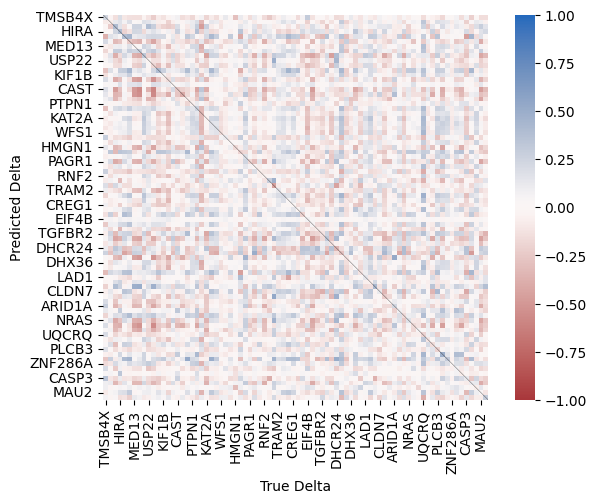

In [12]:
# Load
imputed_means = pd.read_csv('../plots/vcc/imputed_means.csv', index_col=0)
raw_means = pd.read_csv('../plots/vcc/raw_means.csv', index_col=0).iloc[:imputed_means.shape[0]]

# Transform
# imputed_means[:], = preprocessing_nopca.inverse_transform([imputed_means.to_numpy()])
# raw_means[:], = preprocessing_nopca.inverse_transform([raw_means.to_numpy()])

# Lose information from PCA
# raw_means[:], = preprocessing.inverse_transform(preprocessing.transform([raw_means.to_numpy()]))  # Invalid if log
# raw_means[:], = preprocessing_nopca.transform(preprocessing.inverse_transform(preprocessing.transform(preprocessing_nopca.inverse_transform([raw_means.to_numpy()]))))

# Get differences
imputed_mean_diffs = imputed_means.iloc[2:] - imputed_means.loc['_ctl_post']
# imputed_mean_diffs = imputed_means.iloc[2:] - imputed_means.loc['_ctl_pre']
# imputed_mean_diffs = imputed_means.iloc[2:] - raw_means.loc['_ctl_post']
raw_mean_diffs = raw_means.iloc[2:] - raw_means.loc['_ctl_post']

# Get 1k highly variant genes
assert preprocessing.filter_mask[0] is None
# high_var_idx = preprocessing.standardize_std[0][0].argsort()[::-1][:1000]
high_var_idx = np.array(np.argsort(np.std(adata.X[:1000].log1p().todense(), axis=0))).flatten()[::-1][:200]
high_var_genes = adata.var.index[high_var_idx]

# Compute correlations
cross_correlation = np.corrcoef(imputed_mean_diffs, raw_mean_diffs)[:imputed_mean_diffs.shape[0], -raw_mean_diffs.shape[0]:]
# cross_correlation = np.corrcoef(imputed_mean_diffs[high_var_genes], raw_mean_diffs[high_var_genes])[:imputed_mean_diffs.shape[0], -raw_mean_diffs.shape[0]:]
cross_correlation = pd.DataFrame(cross_correlation, index=imputed_mean_diffs.index, columns=raw_mean_diffs.index)

# Dendogram sorting
# dist = scipy.spatial.distance.pdist(cross_correlation.T)
# linkage = scipy.cluster.hierarchy.linkage(dist, method='ward')
# ordered_linkage = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, dist)
# ordered_leaves = scipy.cluster.hierarchy.leaves_list(ordered_linkage)
# cross_correlation = cross_correlation.iloc[ordered_leaves, ordered_leaves]

# Format correlation matrix
cross_correlation_scaled_col = (cross_correlation - np.min(cross_correlation, axis=0)) / (np.max(cross_correlation, axis=0) - np.min(cross_correlation, axis=0))
cross_correlation_scaled_row = (cross_correlation - np.min(cross_correlation, axis=1)) / (np.max(cross_correlation, axis=1) - np.min(cross_correlation, axis=1))
cross_correlation_rank = cross_correlation.shape[0] - np.argsort(np.argsort(cross_correlation, axis=0), axis=0)
cross_correlation_rank = pd.DataFrame(cross_correlation_rank, index=imputed_mean_diffs.index, columns=raw_mean_diffs.index)

# Diagonal summary
pert_summary = pd.DataFrame({
    'Gene': cross_correlation.index,
    'Rank': np.diag(cross_correlation_rank),
    'Correlation': np.diag(cross_correlation),
    'Observed Expression': raw_means.loc['_ctl_post', raw_mean_diffs.index],
    'Observed Knockdown': np.diag(raw_mean_diffs[raw_mean_diffs.index]),
    'Observed Knocked Expression': raw_means.loc['_ctl_post', raw_mean_diffs.index] + np.diag(raw_mean_diffs[raw_mean_diffs.index]),
    'Observed Knockdown Rank': 1 + np.diag(np.argsort(np.argsort(raw_mean_diffs[raw_mean_diffs.index], axis=0), axis=0)),
    'Imputed Expression': imputed_means.loc['_ctl_post', imputed_mean_diffs.index],
    'Imputed Knockdown': np.diag(imputed_mean_diffs[imputed_mean_diffs.index]),
    'Imputed Knocked Expression': imputed_means.loc['_ctl_post', imputed_mean_diffs.index] + np.diag(imputed_mean_diffs[imputed_mean_diffs.index]),
    'Imputed Knockdown Rank': 1 + np.diag(np.argsort(np.argsort(imputed_mean_diffs[imputed_mean_diffs.index], axis=0), axis=0))})
pert_summary['Ratio'] = pert_summary['Imputed Knockdown'] / pert_summary['Observed Knockdown']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(cross_correlation, cmap='vlag_r', vmin=-1, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_scaled_col, cmap='Blues', vmin=0, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_scaled_row, cmap='Blues', vmin=0, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_rank, cmap='Blues_r', vmin=1, vmax=cross_correlation.shape[0], ax=ax)
ax.plot([0, cross_correlation.shape[0]], [0, cross_correlation.shape[0]], lw=.2, color='black')
ax.set(xlabel='True Delta', ylabel='Predicted Delta')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_aspect('equal')


In [13]:
pert_summary


,Gene,Rank,Correlation,Observed Expression,Observed Knockdown,Observed Knocked Expression,Observed Knockdown Rank,Imputed Expression,Imputed Knockdown,Imputed Knocked Expression,Imputed Knockdown Rank,Ratio
TMSB4X,TMSB4X,6,0.229474,134.622680,-128.224164,6.398516,1,23.964730,-23.964443,0.000287,1,0.186895
PRCP,PRCP,59,-0.071271,6.034183,-5.681836,0.352347,1,0.965221,-0.964939,0.000282,2,0.169829
TADA1,TADA1,1,0.400520,1.155387,-1.102351,0.053036,1,0.191094,-0.190180,0.000914,3,0.172523
HIRA,HIRA,1,0.387602,9.085577,-1.008929,8.076648,4,1.536102,-1.535562,0.000540,1,1.521972
IGF2R,IGF2R,3,0.383245,3.525213,-3.179121,0.346092,1,0.556106,-0.555826,0.000280,5,0.174836
...,...,...,...,...,...,...,...,...,...,...,...,...
CASP3,CASP3,13,0.119727,10.752771,-10.229146,0.523625,1,2.034899,-2.035015,-0.000116,3,0.198943
MAST2,MAST2,24,0.108436,1.790384,-1.676682,0.113703,1,0.340642,-0.339770,0.000872,5,0.202645
HAT1,HAT1,68,-0.074769,11.403163,-10.912432,0.490731,1,2.042834,-2.042475,0.000358,2,0.187170
MAU2,MAU2,30,0.037271,0.185602,-0.173849,0.011753,1,0.024132,-0.023812,0.000320,13,0.136968


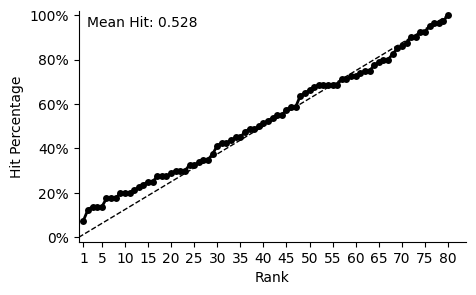

In [14]:
# Get hit df
df = pd.DataFrame({'Rank': 1+np.arange(pert_summary.shape[0])})
df['Hits'] = df['Rank'].apply(lambda r: (pert_summary['Rank'] <= r).sum())
df['Hit Percentage'] = df['Hits'] / pert_summary.shape[0]
auc = df['Hit Percentage'].mean()  # * (df.shape[0]/(df.shape[0]+1))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(df, x='Rank', y='Hit Percentage', lw=2, marker='.', markersize=10, markeredgecolor='none', color='black', ax=ax)
sns.despine(ax=ax)
ax.set_xlim(left=0)
ax.set_ylim(-.02, 1.02)
ax.set_xticks([1]+np.arange(5, pert_summary.shape[0]+5, 5).tolist())
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.))
ax.text(.02, .98, f'Mean Hit: {auc:.3f}', ha='left', va='top', fontsize='medium', transform=ax.transAxes)
ax.plot([0, pert_summary.shape[0]], [0, 1], ls='--', lw=1, color='black');


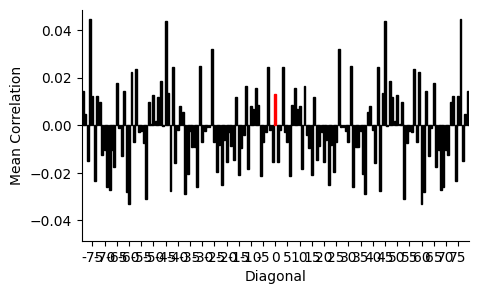

In [15]:
# Get hit df
df = pd.DataFrame({'Diagonal': np.arange(-pert_summary.shape[0]+1, pert_summary.shape[0])})
diag_corr = [np.diag(np.roll(cross_correlation, i, axis=0)).mean() for i in range(cross_correlation.shape[0])]
df['Mean Correlation'] = diag_corr[:0:-1] + diag_corr

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
bar = sns.barplot(df, x='Diagonal', y='Mean Correlation', color='black', edgecolor='black', ax=ax)
# Highlight
ax.patches[len(diag_corr)-1].set(color='red', edgecolor='red')
# Styling
sns.despine(ax=ax)
max_ylim = max(*ax.get_ylim())
ax.set_ylim(-max_ylim, max_ylim)
xticks = np.arange(0, len(diag_corr), 5)
xticks = np.concat([-xticks[:0:-1], xticks])
ax.set(xticks=xticks+df['Diagonal'].max(), xticklabels=xticks);


/tmp/ipykernel_97858/2340559097.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  bar = sns.barplot(df.loc[df['Type'].str.endswith('Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue'], edgecolor='none', width=.8, ax=ax)


/tmp/ipykernel_97858/2340559097.py:16: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  bar = sns.barplot(df.loc[df['Type'].str.endswith('Knocked Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral'], edgecolor='none', width=.4, ax=ax)


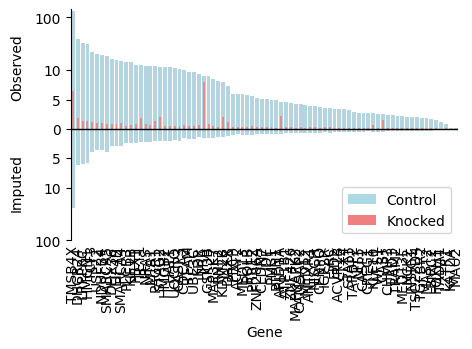

In [16]:
# Pivot
df = pert_summary.melt(
    id_vars='Gene',
    value_vars=[
        'Observed Expression', 'Imputed Expression',
        # 'Observed Knockdown', 'Imputed Knockdown',
        'Observed Knocked Expression', 'Imputed Knocked Expression'],
    var_name='Type', value_name='Value').sort_values('Value', ascending=False)
df.loc[df['Type'].str.startswith('Imputed'), 'Value'] *= -1

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# bar = sns.barplot(df.loc[df['Type'].str.endswith('Observed')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue', 'lightblue'], edgecolor='none', width=.8, ax=ax)
# bar = sns.barplot(df.loc[df['Type'].str.startswith('Imputed')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral', 'lightcoral'], edgecolor='none', width=.4, ax=ax)
bar = sns.barplot(df.loc[df['Type'].str.endswith('Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue'], edgecolor='none', width=.8, ax=ax)
bar = sns.barplot(df.loc[df['Type'].str.endswith('Knocked Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral'], edgecolor='none', width=.4, ax=ax)
# bar.get_legend().set_title('')
ax.set_yscale('symlog', linthresh=10)
ax.axhline(y=0, lw=1., color='black')
yticks = [-100, -10, -5, 0, 5, 10, 100]
ax.set(yticks=yticks, yticklabels=np.abs(yticks))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Styling
sns.despine(bottom=True, ax=ax)
ax.tick_params(axis='x', which='major', length=0)
ax.set_ylabel(None)
# ax.text(-.12, .75, 'Expression', ha='right', va='center', rotation=90, transform=ax.transAxes)
# ax.text(-.12, .25, 'Knockdown', ha='right', va='center', rotation=90, transform=ax.transAxes)
ax.text(-.12, .75, 'Observed', ha='right', va='center', rotation=90, transform=ax.transAxes)
ax.text(-.12, .25, 'Imputed', ha='right', va='center', rotation=90, transform=ax.transAxes)
# Legend
patches = [
    mpl.patches.Patch(facecolor='lightblue', edgecolor='none'),
    mpl.patches.Patch(facecolor='lightcoral', edgecolor='none')]
# labels = ['Observed', 'Imputed']
labels = ['Control', 'Knocked']
ax.legend(patches, labels, loc='lower right');
